<a href="https://colab.research.google.com/github/YosefLab/popV/blob/main/docs/tutorials/notebooks/tabula_sapiens_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Tabula Sapiens as a reference for annotating new datasets

This notebook allows you to annotate your data with a number of annotation methods using the Tabula Sapiens dataset as the reference.

Initial setup:
Using pre-trained models is only supported in python 3.11 due to inconsistencies in pickle. If Google Colab updates their python version, we will also update our pretrained models.


Integration Methods Provided:
- scVI [(Lopez et al. 2018)](https://www.nature.com/articles/s41592-018-0229-2)
- bbKNN [(Polański et al. 2020)](https://academic.oup.com/bioinformatics/article/36/3/964/5545955)
- Scanorama [(He et al. 2019)](https://www.nature.com/articles/s41587-019-0113-3)
- Harmony [(Korsunsky et al. 2019)](https://www.nature.com/articles/s41592-019-0619-0)

Annotation Methods:
- KNN on integrated spaces
- scANVI [(Xu et al. 2021)](https://www.embopress.org/doi/full/10.15252/msb.20209620)
- OnClass [(Wang et al. 2020)](https://www.biorxiv.org/content/10.1101/810234v2)
- Celltypist [(Dominguez Conde et al. 2022)](https://www.science.org/doi/10.1126/science.abl5197)
- SVM
- RandomForest
- XGboost

To use the notebook, simply connect to your Google Drive account, set the necessary arguments, select your methods, and run all the code blocks!

Last edited: 01/23/2025



In [1]:
!pip install -q "popv @ git+https://github.com/YosefLab/popv.git@faiss_nn"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 16.6 MB/s et

## Step 1: Setup environment (Restart Notebook after installation)

We omit the output of those lines for readability. First we change the encoding to UTF8 - python default.

In [1]:
import os

os.environ["PYTHONUTF8"] = "1"
os.environ["SCIPY_ARRAY_API"] = "1"

In [2]:
import pandas as pd
import popv
import scanpy as sc

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Pretrained models on huggingface are trained with Python 3.11. Detected Python {sys.version.split()[:2]} will not load these models.
  exec(code_obj, self.user_global_ns, self.user_ns)
Instructions for updating:
non-resource variables are not supported in the long term


popV provides setting in popv.settings. If you have a GPU and a large dataset, specifically set popv.cuml = True after installing a GPU enabled version of faiss and rapids_singlecell. This will use GPU-accelerated code in popV and can be an order faster.

## Step 2: Load your data (User Action Required)
Here we provide three options to load your data:
1. Connect to Google Drive (highly recommended)
2. Download your data from the cloud and save into this session or on Google drive.
3. Upload your data manually into this session (files are not persistent and will be deleted when session is closed)

As an example, we use a subsampled version of the [Lung Cell Atlas](https://hlca.ds.czbiohub.org/) \[1] for our query data.

\[1] Travaglini, K. et al. A molecular cell atlas of the human lung from single-cell RNA sequencing. *Nature* **587**, 619–625(2020).

In [3]:
input_file = {
    "source": "cellxgene",
    "path": "tmp/LCA.h5ad",
    "url": "https://cellxgene.cziscience.com/e/8c42cfd0-0b0a-46d5-910c-fc833d83c45e.cxg/",
}
os.makedirs(os.path.dirname(input_file["path"]), exist_ok=True)

if input_file["source"] == "gdrive":
    # OPTION 1: Connect to Google Drive.
    from google.colab import drive

    drive.mount("/content/drive")
    query_adata = sc.read(input_file["path"])
elif input_file["source"] == "cellxgene":
    # OPTION 2: Download from CELLxGENE URL.
    import cellxgene_census

    try:  # CELLxGENE throws error if file exists.
        cellxgene_census.download_source_h5ad(
            dataset_id=input_file["url"].rsplit("/", 2)[1].rsplit(".")[0],
            census_version="stable",
            to_path=input_file["path"],
        )
    except ValueError:
        pass
    query_adata = sc.read_h5ad(input_file["path"])
else:
    query_adata = sc.read(input_file["path"], backup_url=input_file["url"])

query_adata.obs_names_make_unique()
# Downsample to reduce RAM usage. Not necessary with Google Colab Pro.
sc.pp.subsample(query_adata, 0.2)

Downloading: 100%|██████████| 564M/564M [00:13<00:00, 44.6MB/s]


In [4]:
# CELLxGENE census stores normalized counts in adata.X and raw counts in adata.raw.X. We need raw counts.
query_adata.X = query_adata.raw.X
query_adata.X.data

## Step 3 (User Action Required): Setting Up Annotation Parameters

Here is where you set the parameters for the automated annotation.

Arguments:
- **huggingface_repo:** Reference model to use. See hugingface for further information (https://huggingface.co/popV).
- **save_location:** location to save results to. By default will save to a folder named `annotation_results`. It is highly recommended you provide a Google Drive folder here.
- **query_batch_key:** key in `query_adata.obs` for batch correction. Set to None for no batch correction.
- **algorithms:** these are the methods to run. By default, will run all methods provided for the reference data.
Options: ["knn_on_scvi_pred", "scanvi_pred", "knn_on_bbknn_pred", "svm_pred", "rf_pred", "onclass_pred", "knn_on_scanorama_pred".

In [6]:
huggingface_repo = "popV/Tabula_Sapiens4_Lung"
query_batch_key = "donor_id"
algorithms = None

## Step 4: Perform annotation
No more user input required! Just run all the following code blocks.


### Optional: Train model from scratch.


We provide pretrained models based on Tabula sapiens on huggingface. In case, you want to train popV on your own data this commented code block provides all arguments to do so.

In [8]:
# from huggingface_hub import snapshot_download

# snapshot_download(repo_id="popV/ontology", repo_type="dataset", local_dir="tmp/ontology")

# cellxgene_census.download_source_h5ad(
#     dataset_id="0d2ee4ac-05ee-40b2-afb6-ebb584caa867",
#     census_version="stable",
#     to_path="tmp/tabula_sapiens_lung.h5ad",
# )

# ref_adata = sc.read("tmp/tabula_sapiens_lung.h5ad")
# ref_adata.X = ref_adata.raw.X # Get count data in CELLxGENE data.

# # popv.settings.cuml = True # Optional to speed up training
# popv.settings.n_jobs = 10

# output_folder = "tmp/annotation_results"
# os.makedirs(output_folder, exist_ok=True)
# ref_labels_key = "cell_type"
# unknown_celltype_label = "unassigned"  # Label of unlabeled cells
# n_samples_per_label = 100 # Downsamples for some classifiers the dataset.

# query_adata.obs['batch_key'] = query_adata.obs.apply(lambda row: row['donor_id'] + '_' + row['assay'] + '_' + row['tissue'], axis=1)
# ref_adata.obs['batch_key'] = ref_adata.obs.apply(lambda row: row['donor_id'] + '_' + row['assay'] + '_' + row['tissue'], axis=1)
# adata = popv.preprocessing.Process_Query(
#     query_adata,
#     ref_adata,
#     query_batch_key="batch_key",
#     ref_labels_key=ref_labels_key,
#     ref_batch_key="batch_key",
#     unknown_celltype_label=unknown_celltype_label,
#     save_path_trained_models=output_folder,
#     cl_obo_folder="tmp/ontology/",
#     prediction_mode="retrain",
#     n_samples_per_label=n_samples_per_label,
#     hvg=4000,
# ).adata

# popv.annotation.annotate_data(
#     adata,
#     save_path=f"{output_folder}/popv_output",
# )

In [ ]:
huggingface_repo = "popV/tabula_sapiens4_Lung"

In [9]:
hmo = popv.hub.HubModel.pull_from_huggingface_hub(huggingface_repo, cache_dir="tmp/tabula_sapiens")
adata = hmo.annotate_data(
    query_adata,
    query_batch_key=query_batch_key,
    prediction_mode="inference",  # "fast" does not integrate reference and query.
    # gene_symbols="feature_name", # "Uncomment if using gene symbols."
)

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

accuracies.json: 0.00B [00:00, ?B/s]

OnClass.index:   0%|          | 0.00/222 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

celltypist.pkl:   0%|          | 0.00/714k [00:00<?, ?B/s]

OnClass.data-00000-of-00001:   0%|          | 0.00/27.2M [00:00<?, ?B/s]

OnClass.npz:   0%|          | 0.00/144M [00:00<?, ?B/s]

OnClass.meta:   0%|          | 0.00/108k [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

harmony_knn_classifier.index:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

faiss_index.index:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

metadata.json:   0%|          | 0.00/917 [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

minified_ref_adata.h5ad:   0%|          | 0.00/290M [00:00<?, ?B/s]

obo_dag.joblib:   0%|          | 0.00/321k [00:00<?, ?B/s]

predictions.csv: 0.00B [00:00, ?B/s]

preprocessing.json: 0.00B [00:00, ?B/s]

scanvi/model.pt:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

ref_labels.csv: 0.00B [00:00, ?B/s]

scvi/model.pt:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

scvi_knn_classifier.index:   0%|          | 0.00/4.74M [00:00<?, ?B/s]

svm_classifier.joblib:   0%|          | 0.00/548k [00:00<?, ?B/s]

xgboost_classifier.model:   0%|          | 0.00/8.67M [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

cl.json:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/33.0 [00:00<?, ?B/s]

cl.ontology: 0.00B [00:00, ?B/s]

cl.ontology.nlp.emb:   0%|          | 0.00/155M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

cl_popv.json:   0%|          | 0.00/38.1M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

LLLLLL tmp/tabula_sapiens/models--popV--Tabula_Sapiens3_Lung/snapshots/195d83ca3a06bb045e3b66061650aa5de7094d64 ['checkpoint', 'preprocessing.json', 'OnClass.npz', 'svm_classifier.joblib', 'OnClass.meta', 'metadata.json', 'faiss_index.index', 'OnClass.index', 'README.md', 'accuracies.json', 'OnClass.data-00000-of-00001', 'minified_ref_adata.h5ad', 'obo_dag.joblib', '.gitattributes', 'scvi_knn_classifier.index', 'scanvi', 'popv_output', 'celltypist.pkl', 'scvi', 'ref_labels.csv', 'harmony_knn_classifier.index', 'xgboost_classifier.model']
INFO     Found 92.10000000000001% reference vars in query data.                                                    


 12%|█▎        | 1/8 [00:05<00:38,  5.45s/it]

 38%|███▊      | 3/8 [06:32<11:57, 143.56s/it]

INFO     File                                                                                                      
         tmp/tabula_sapiens/models--popV--Tabula_Sapiens3_Lung/snapshots/195d83ca3a06bb045e3b66061650aa5de7094d64/s
         cvi/model.pt already downloaded                                                                           


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Retraining scvi for 51 epochs.


Training:   0%|          | 0/51 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=51` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=51` reached.
 62%|██████▎   | 5/8 [18:47<13:44, 274.87s/it]

INFO     File                                                                                                      
         tmp/tabula_sapiens/models--popV--Tabula_Sapiens3_Lung/snapshots/195d83ca3a06bb045e3b66061650aa5de7094d64/s
         canvi/model.pt already downloaded                                                                         
INFO     Training for 20 epochs.                                                                                   


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training:   0%|          | 0/20 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


100%|██████████| 8/8 [25:44<00:00, 193.03s/it]


In [10]:
# Optional: save the full anndata will all objects
# adata.write(f'{output_folder}/query_and_reference_popv.h5ad')

In [11]:
# Optional: save the full anndata will all objects
# adata.write(f'{output_folder}/query_and_reference_popv.h5ad')

In [12]:
list(adata.uns["prediction_keys"])

['popv_celltypist_prediction',
 'popv_knn_bbknn_prediction',
 'popv_knn_harmony_prediction',
 'popv_knn_on_scvi_prediction',
 'popv_onclass_prediction',
 'popv_scanvi_prediction',
 'popv_svm_prediction',
 'popv_xgboost_prediction']

In [13]:
cell_types = pd.unique(adata.obs[list(adata.uns["prediction_keys_seen"]) + ["cell_type"]].values.ravel("K"))
palette = sc.plotting.palettes.default_102
celltype_colors = dict(zip(list(cell_types), palette, strict=False))

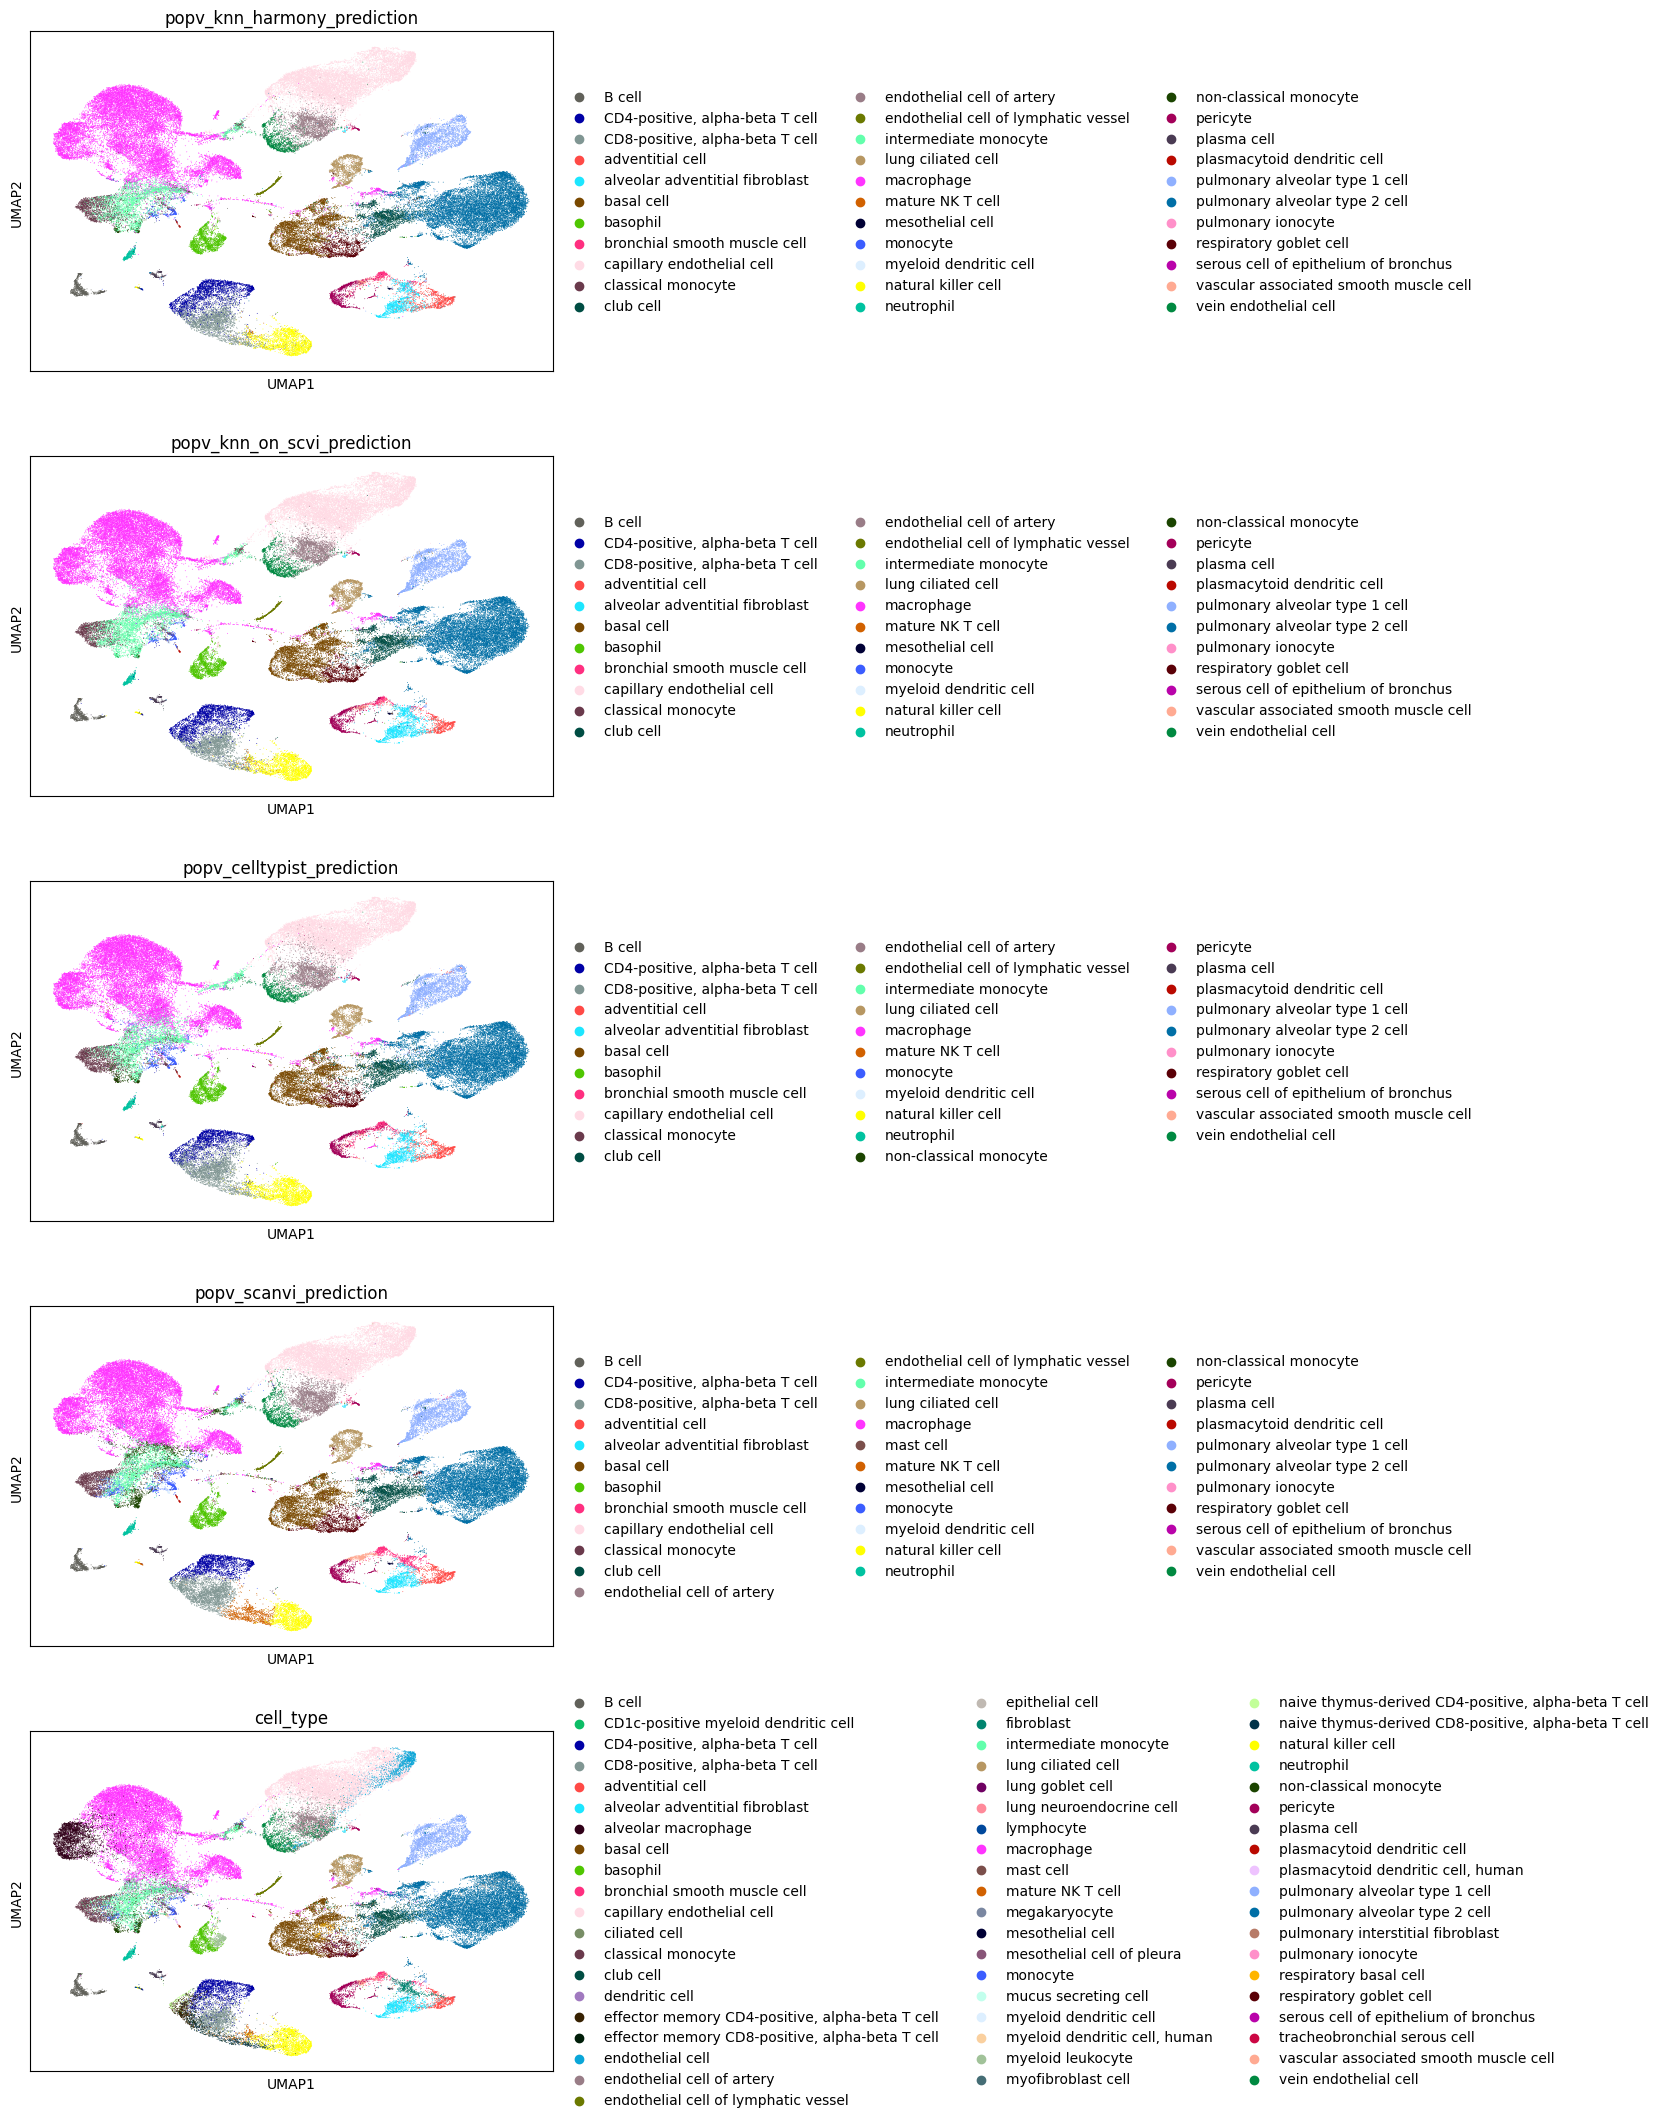

In [14]:
adata.obsm["X_umap"] = adata.obsm["X_umap_scanvi_popv"]

sc.pl.umap(
    adata,
    color=[
        "popv_knn_harmony_prediction",
        "popv_knn_on_scvi_prediction",
        "popv_celltypist_prediction",
        "popv_scanvi_prediction",
        "cell_type",
    ],
    palette=celltype_colors,
    ncols=1,
)

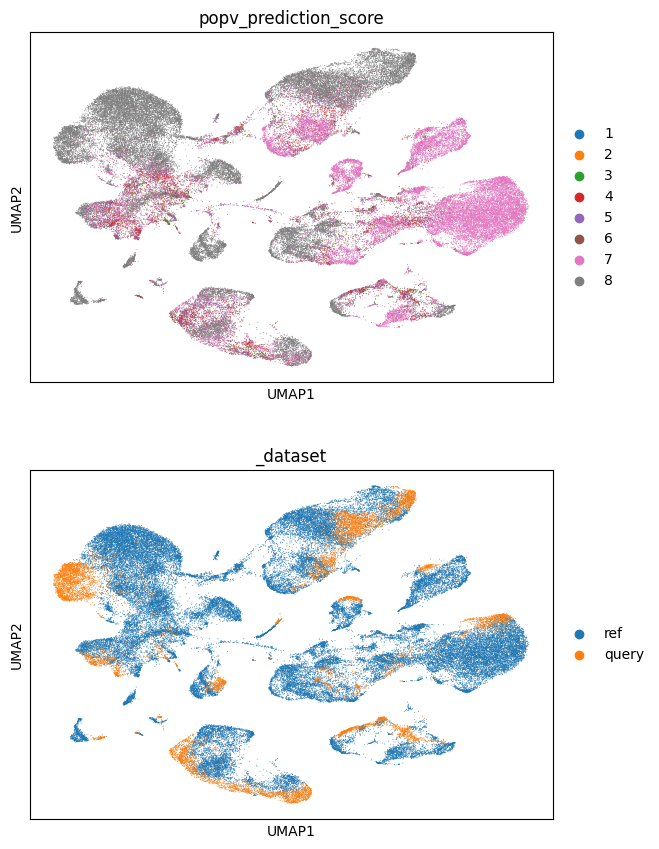

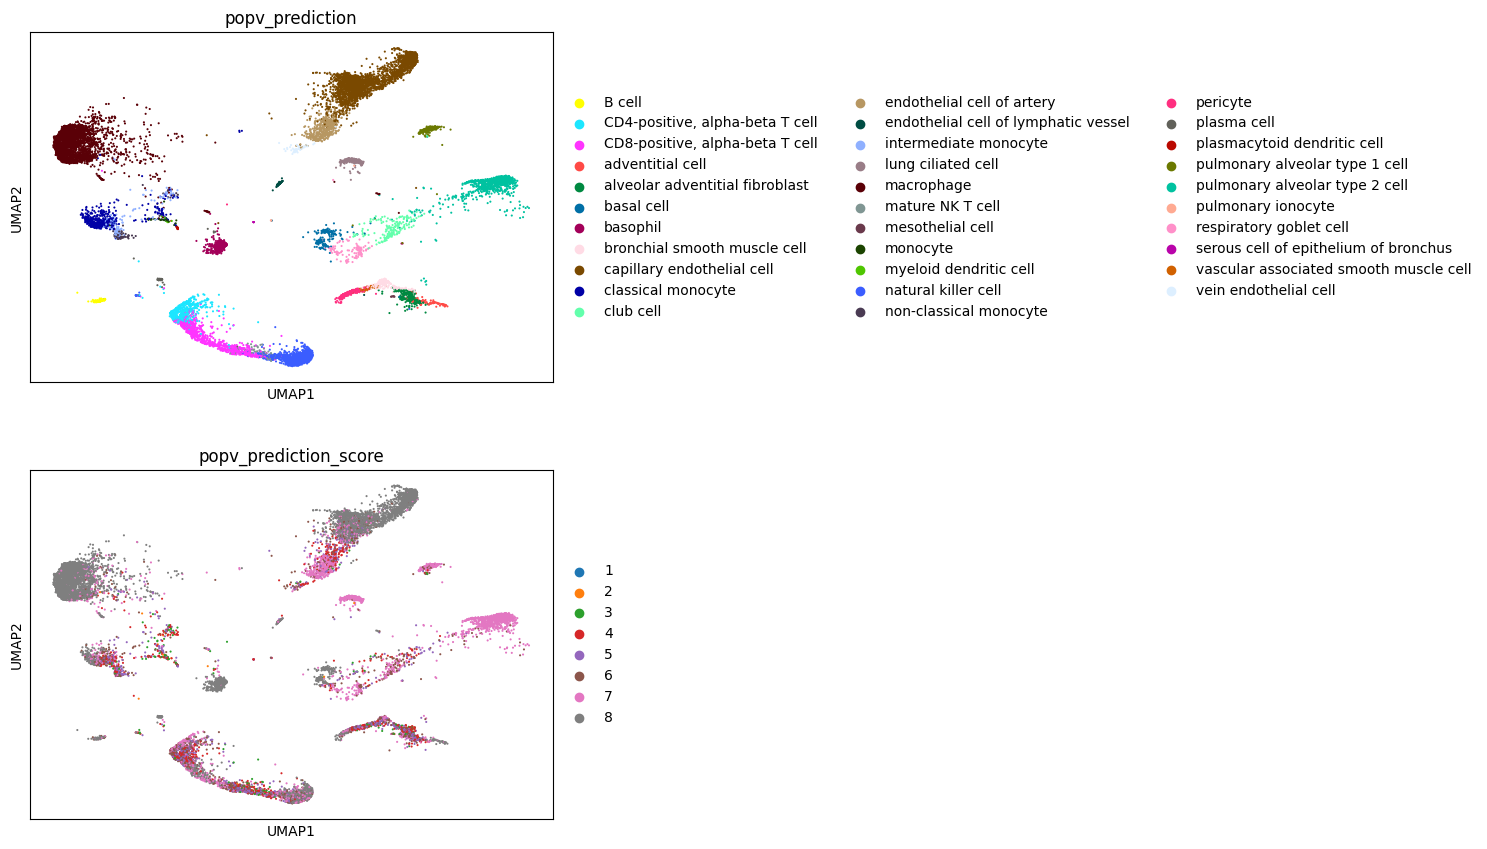

In [15]:
sc.pl.umap(
    adata,
    color=["popv_prediction_score", "_dataset"],
    ncols=1,
)

sc.pl.umap(
    adata[adata.obs["_dataset"] == "query"],
    color=[
        "popv_prediction",
        "popv_prediction_score",
    ],
    ncols=1,
)

## Step 6: Summary Statistics

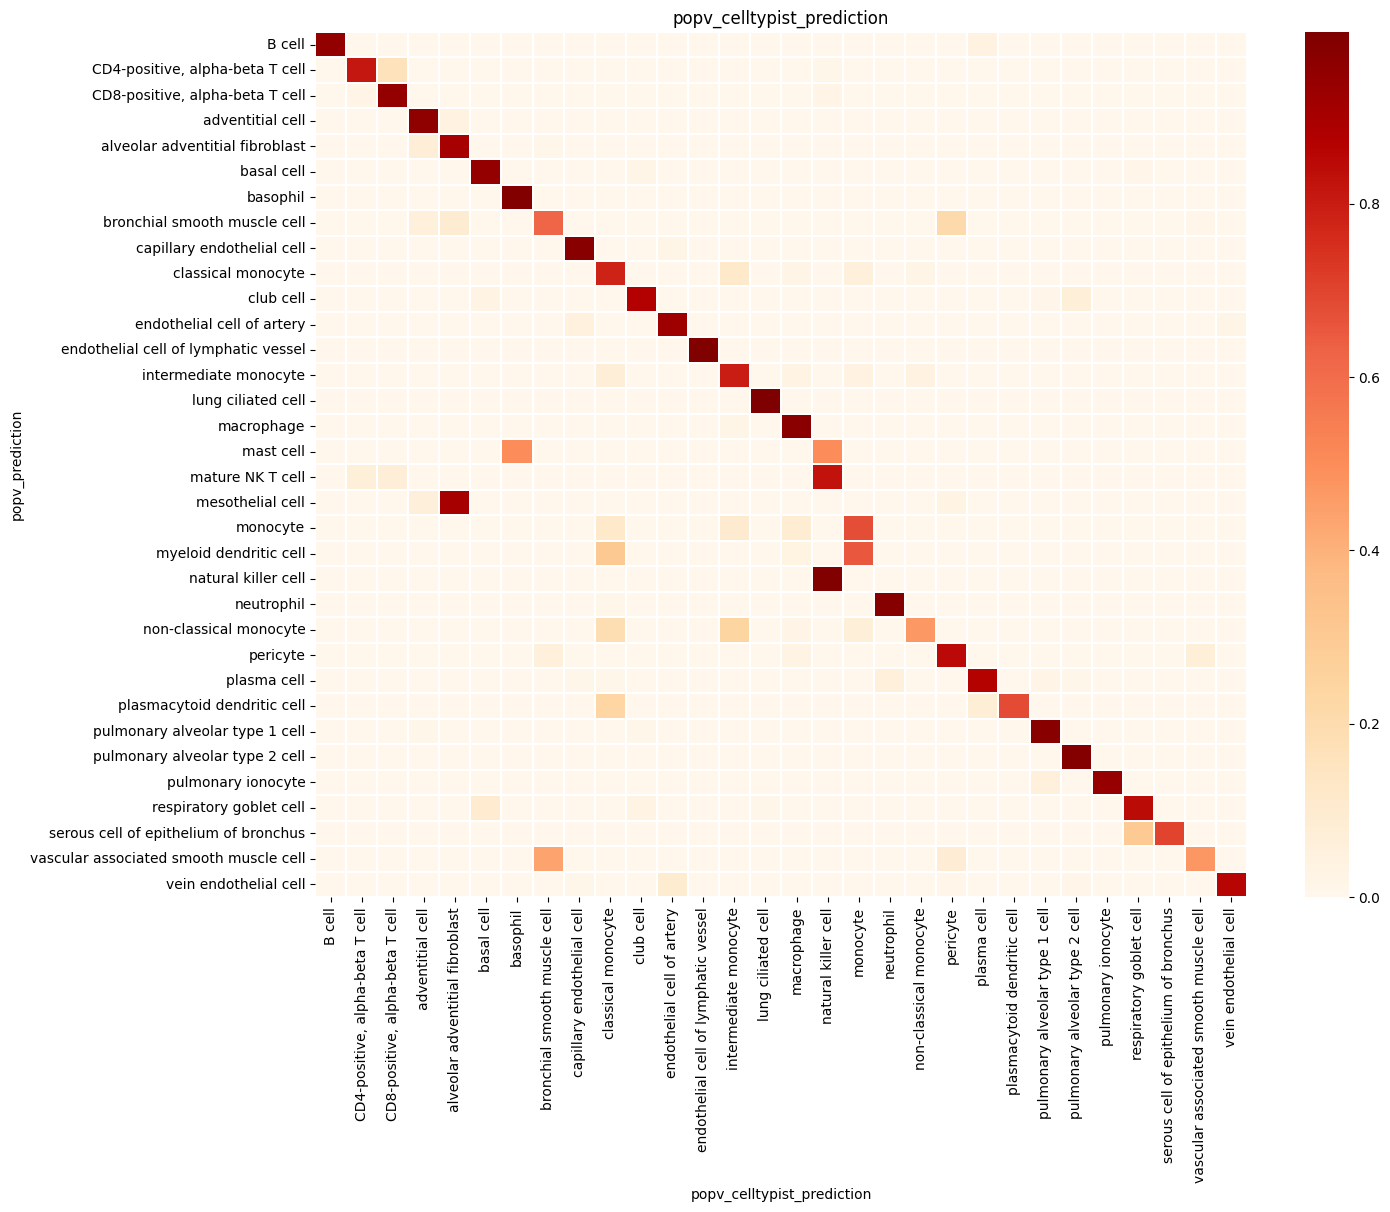

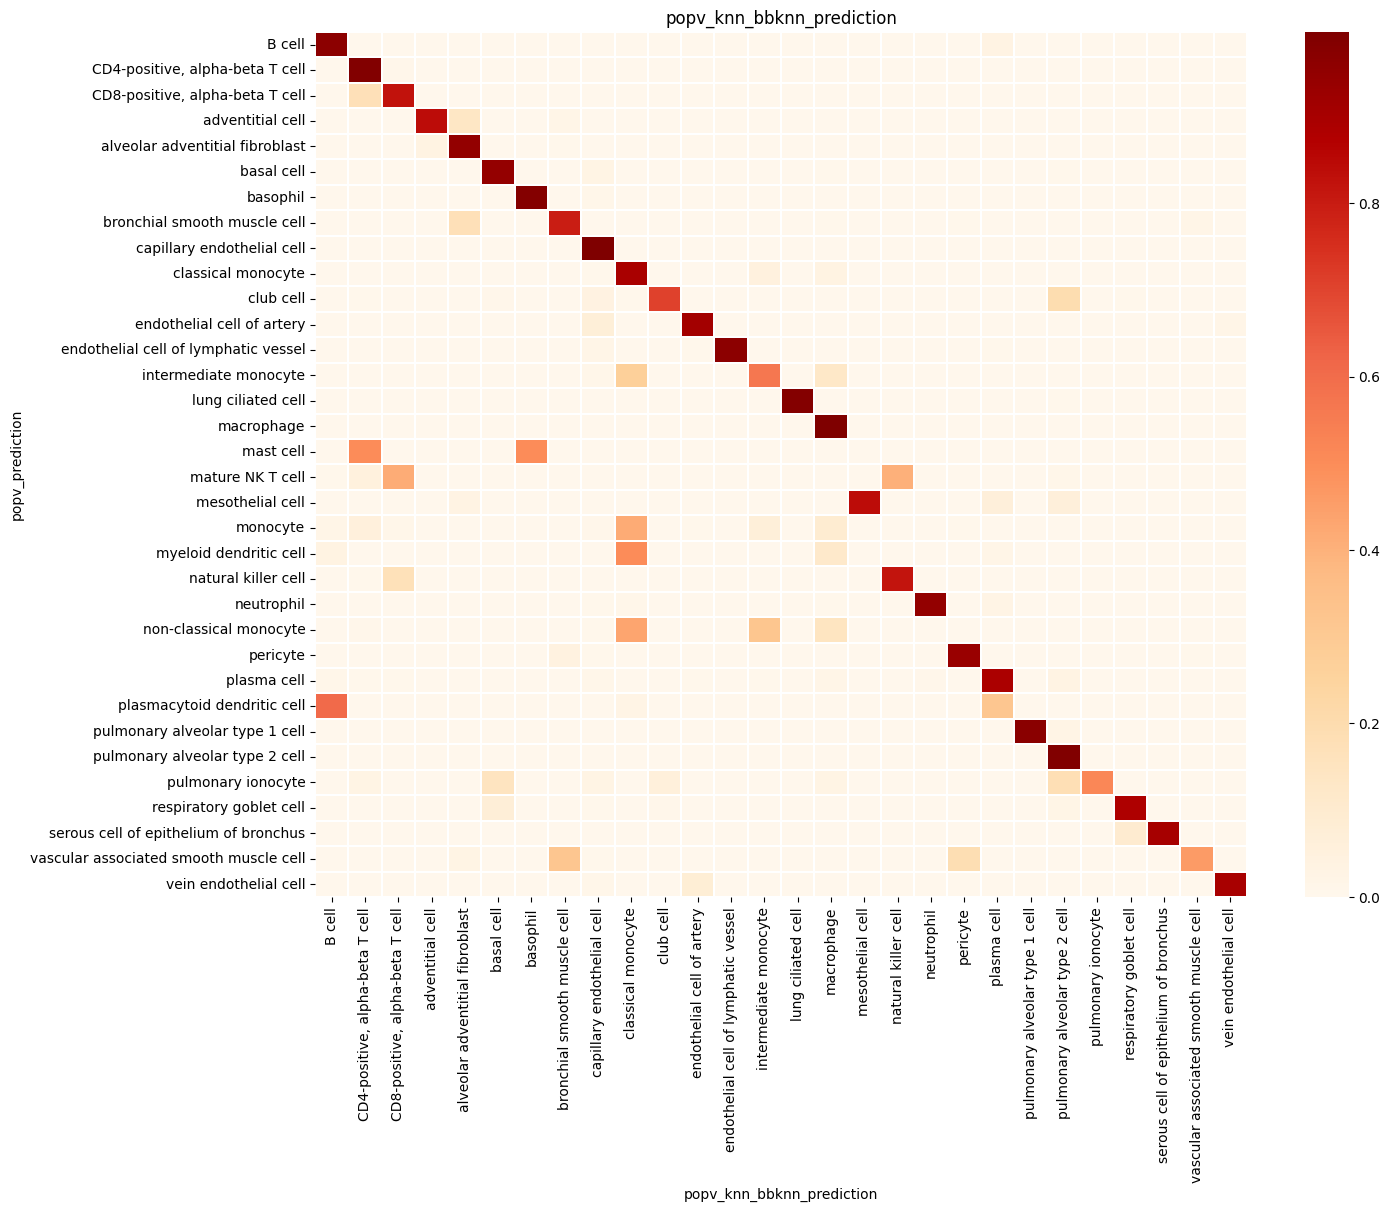

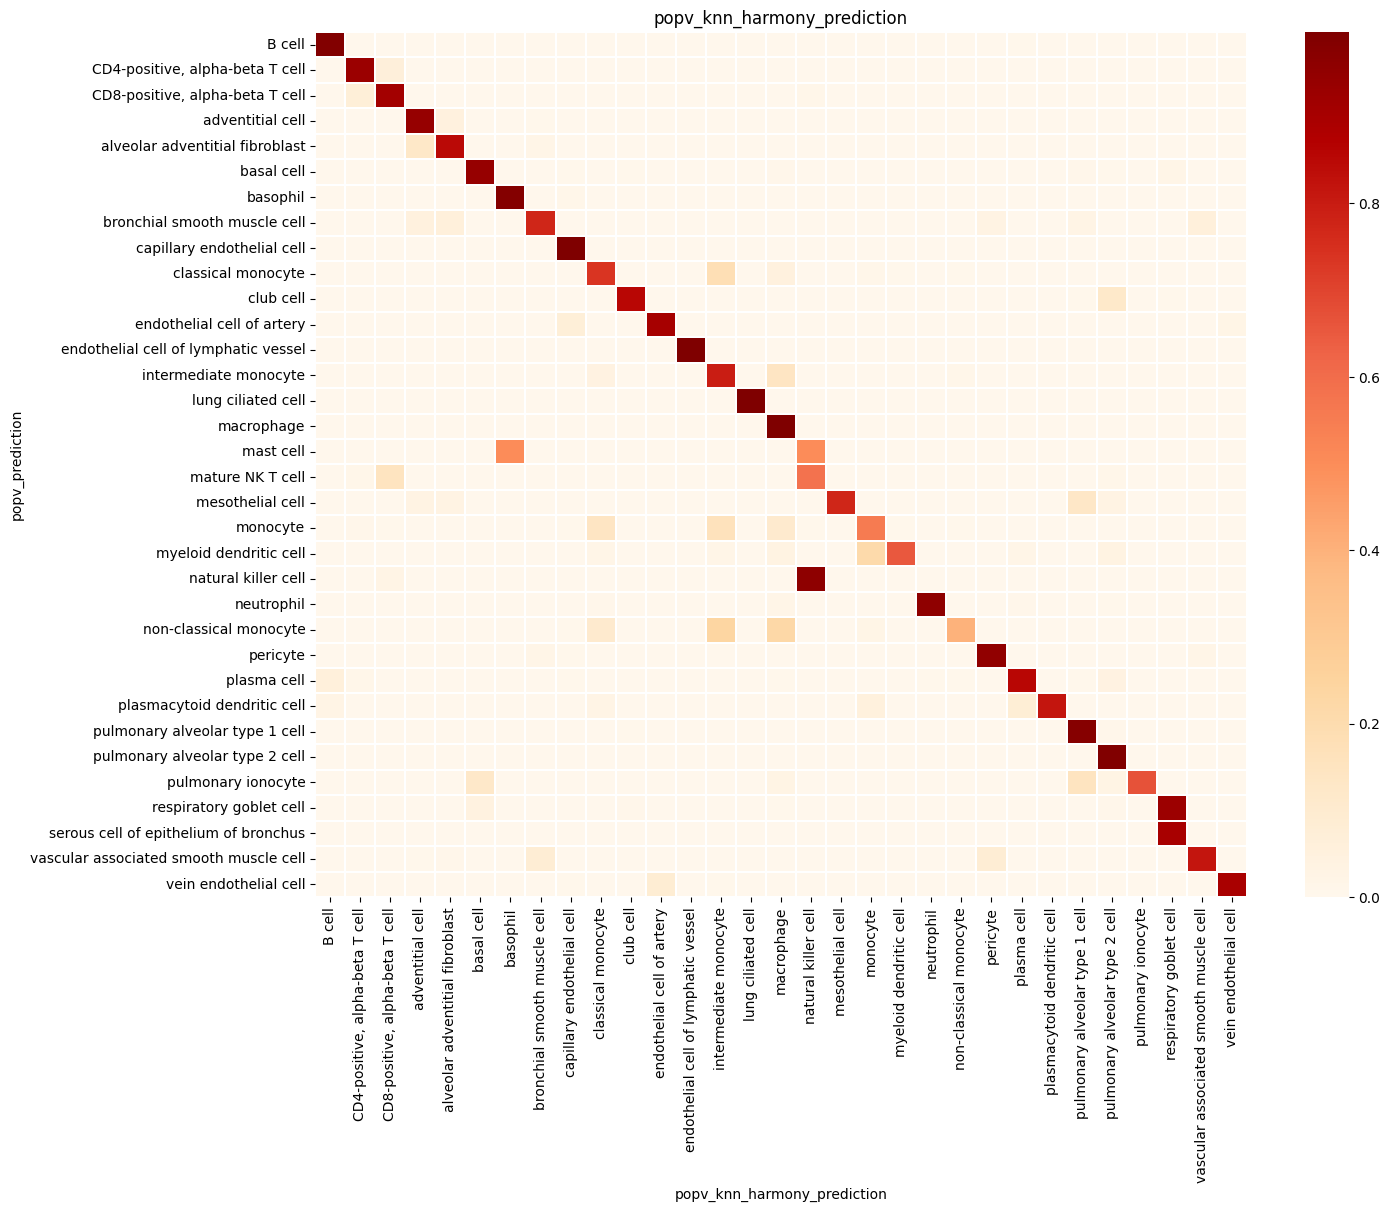

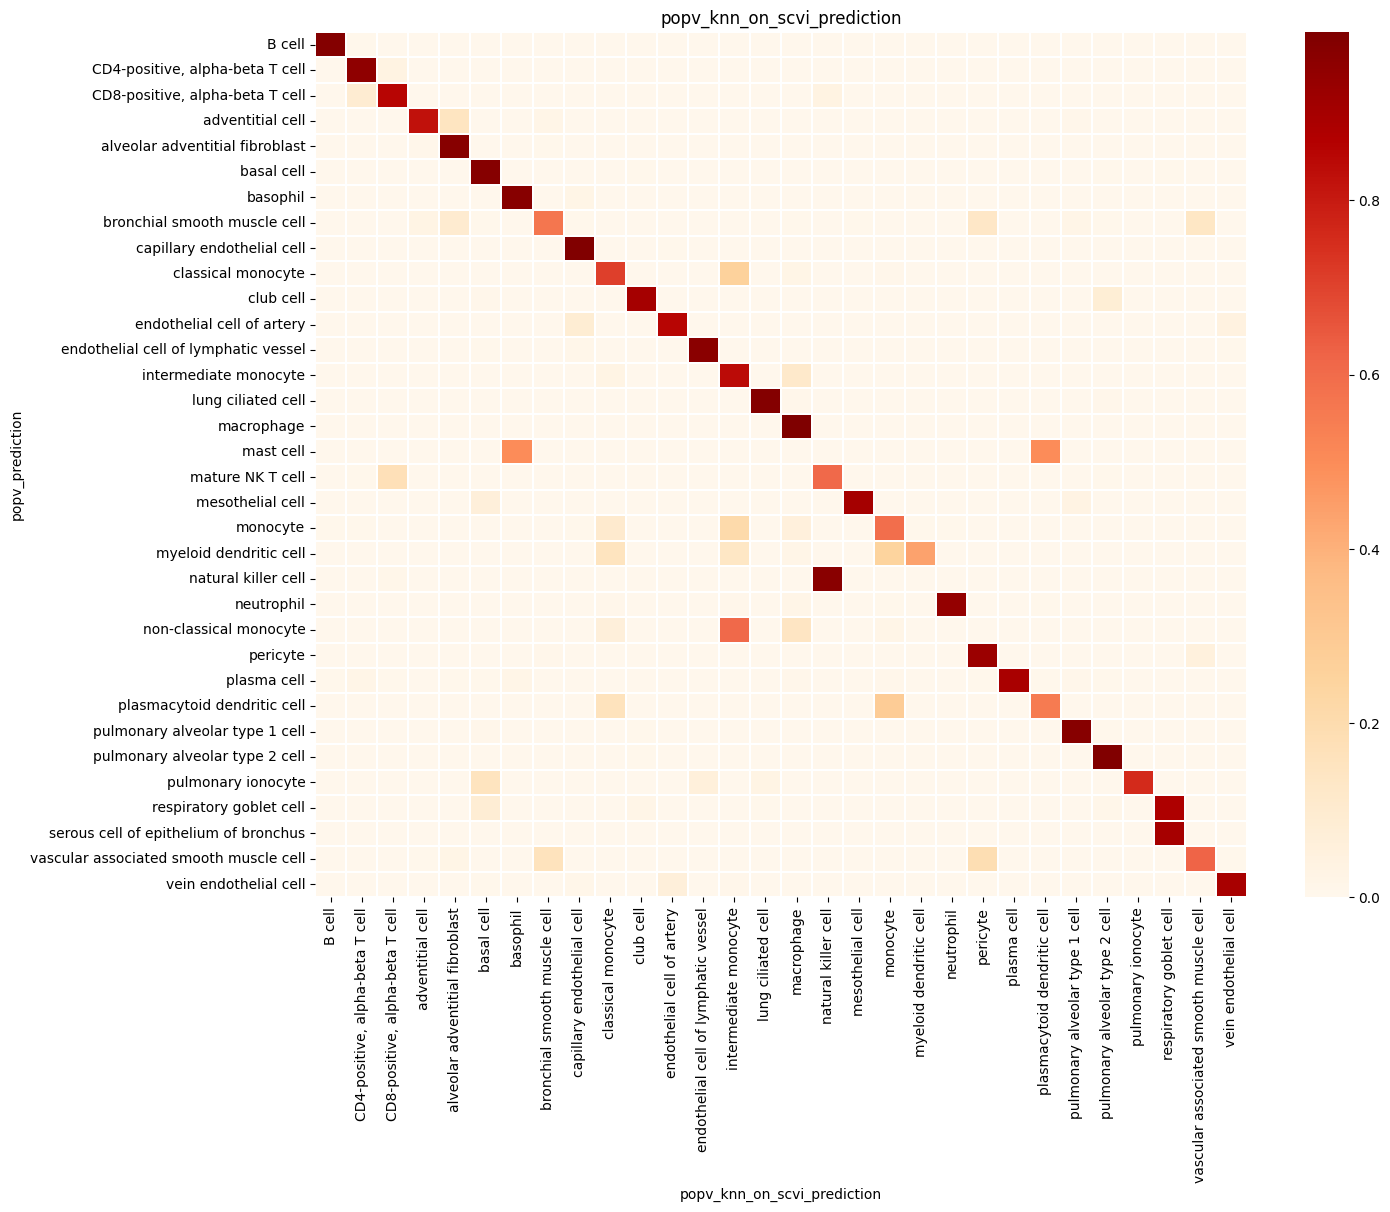

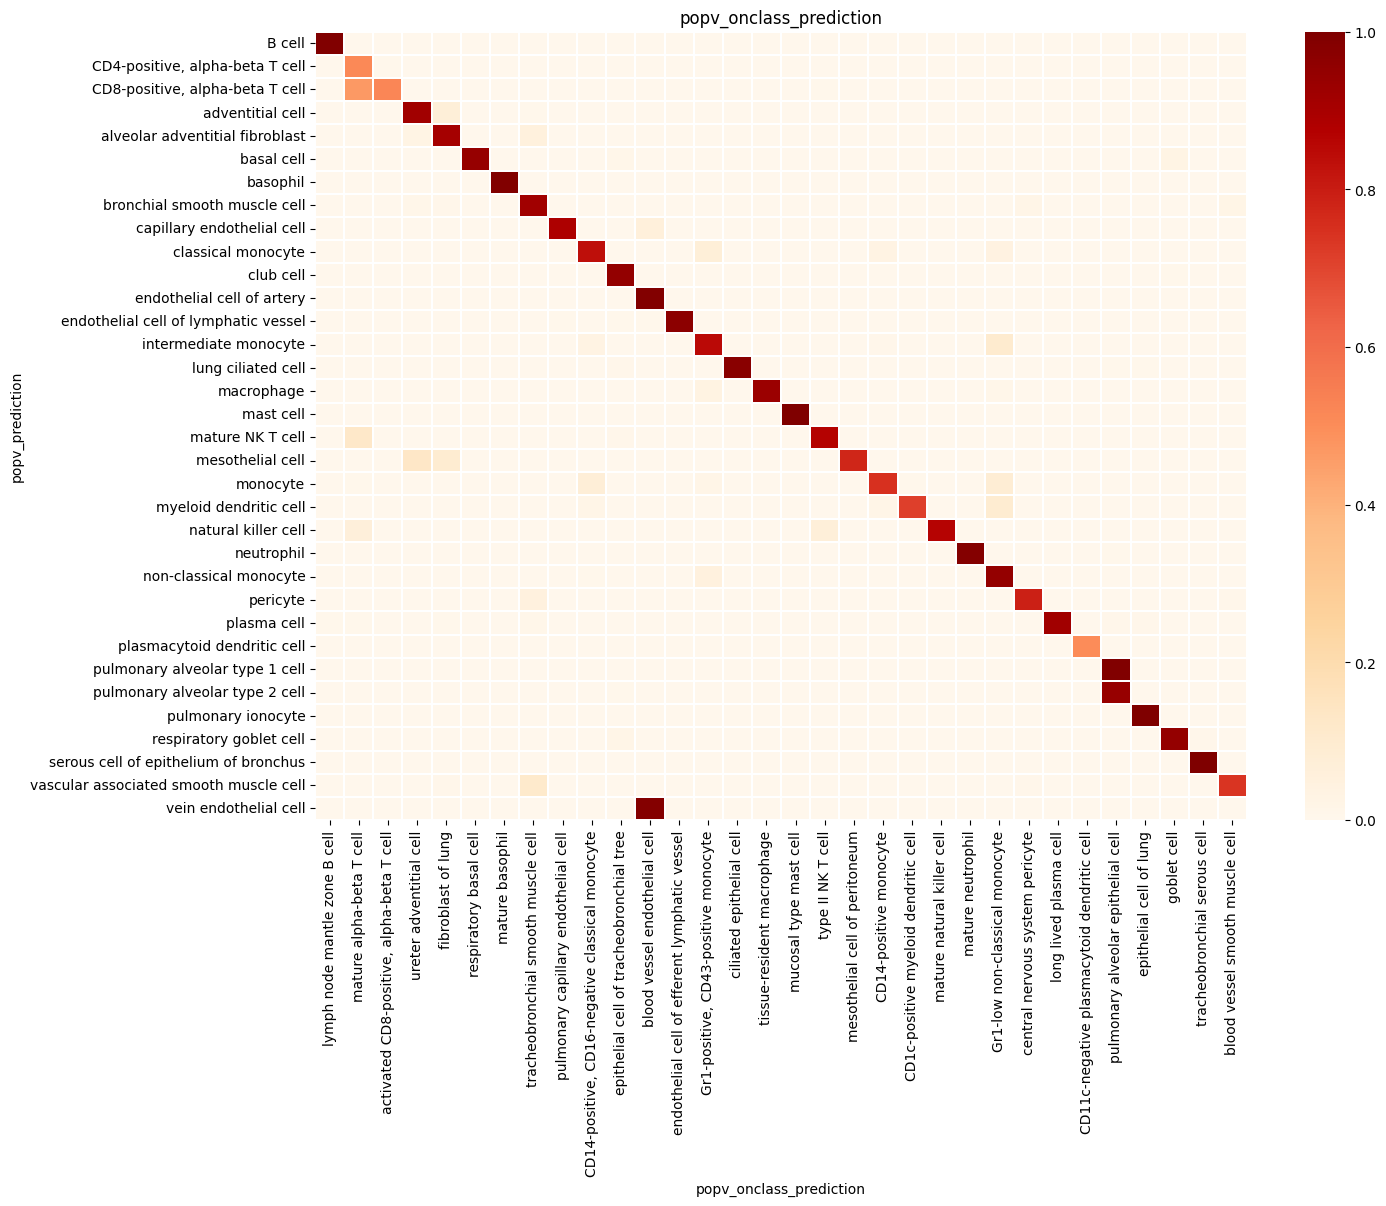

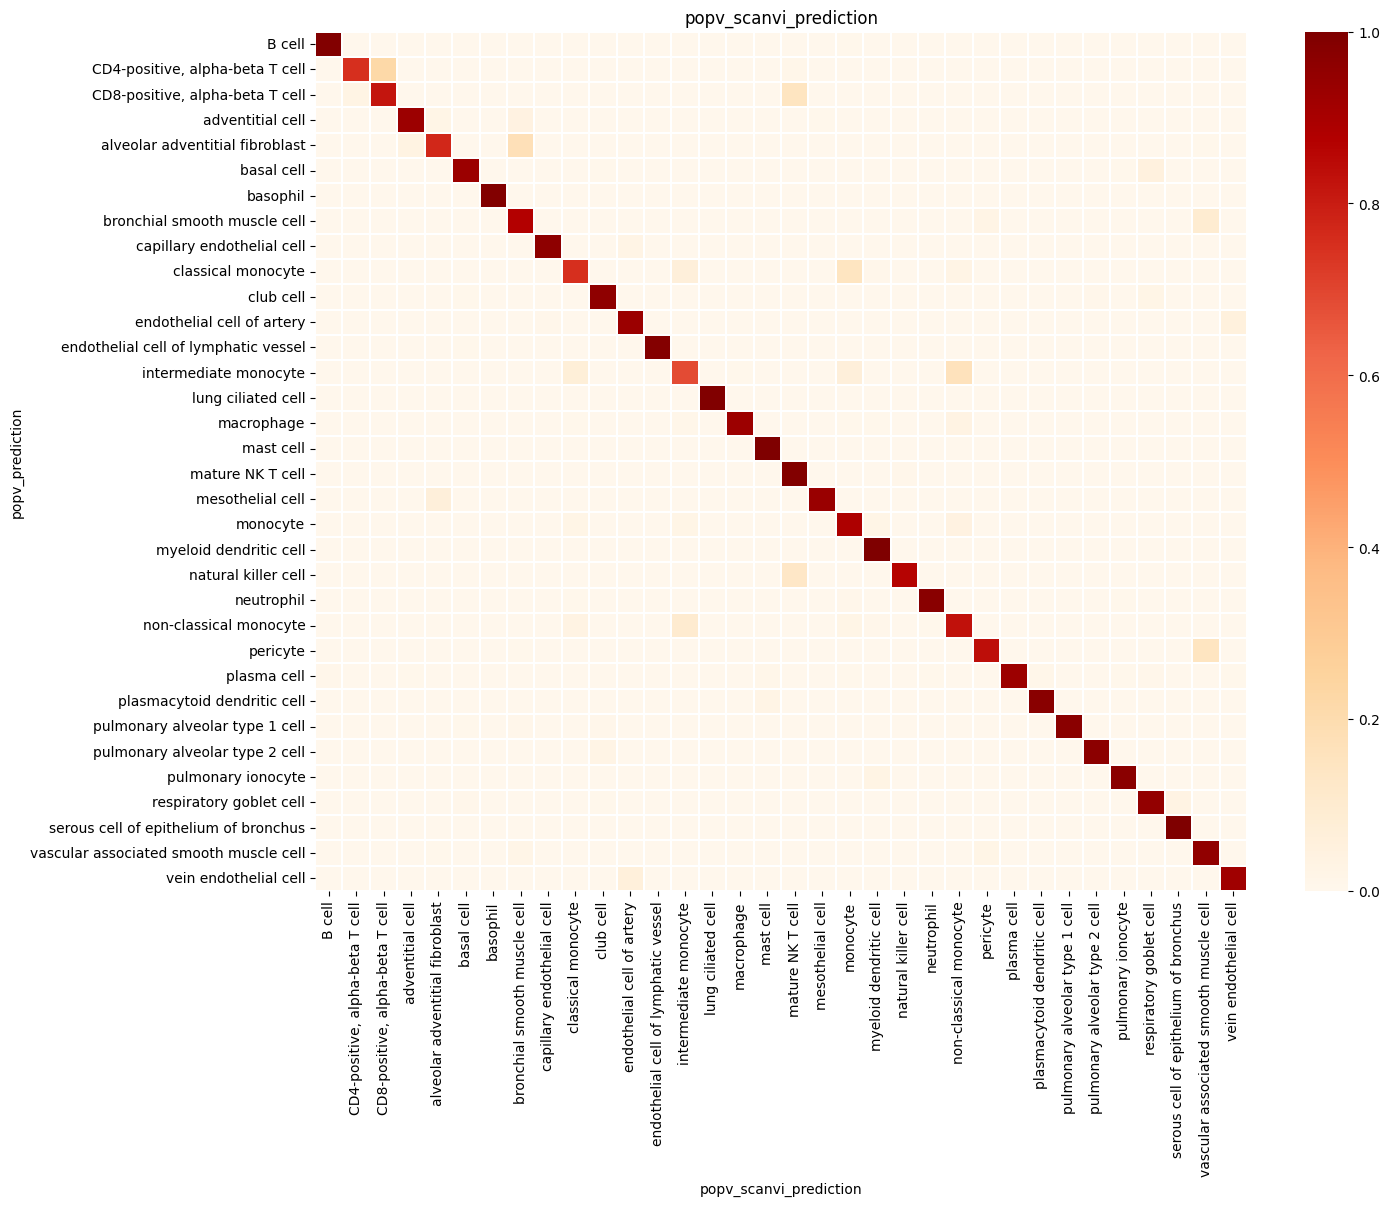

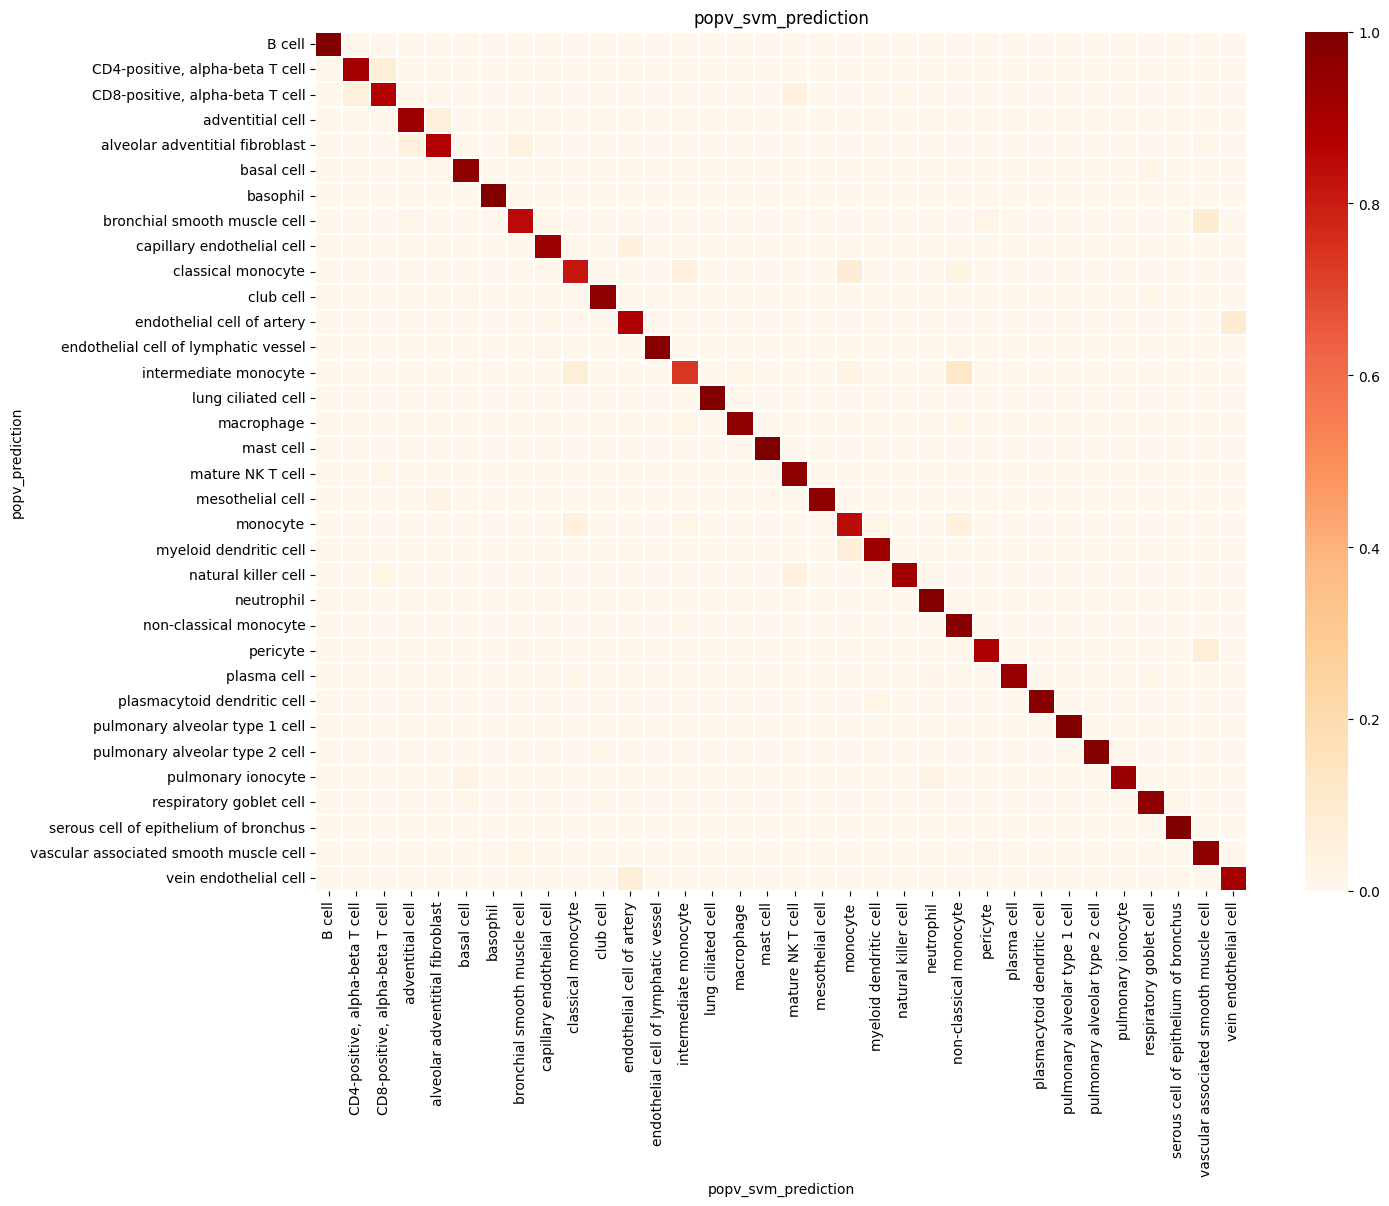

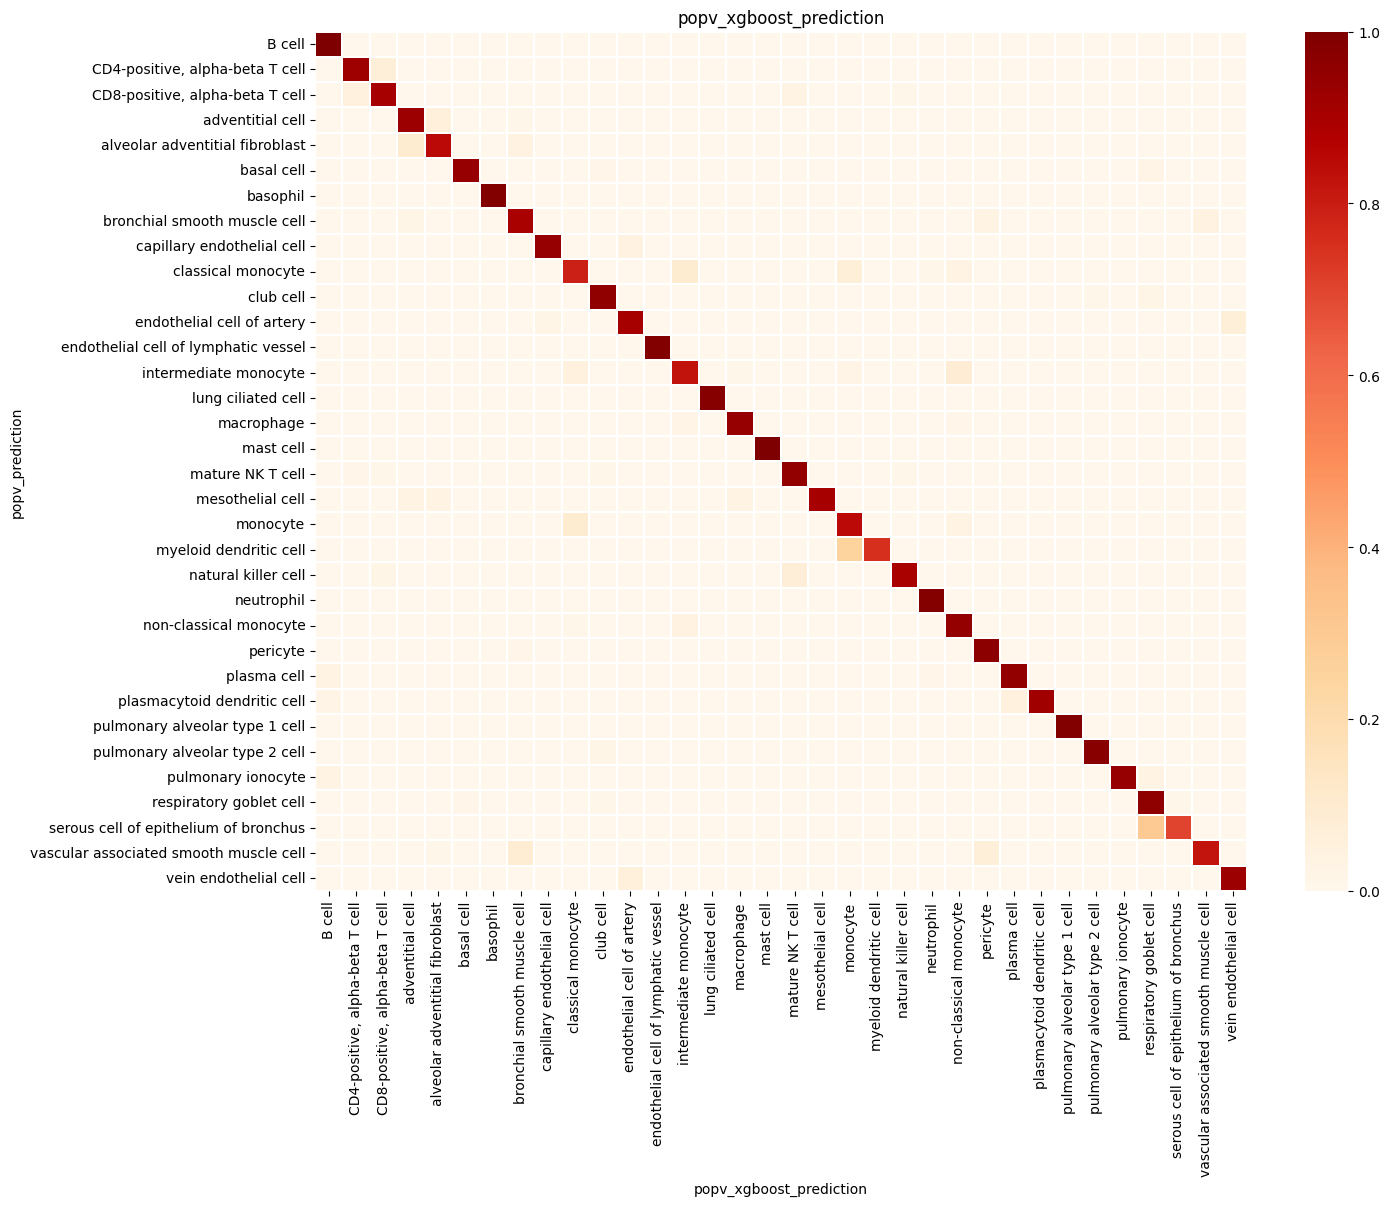

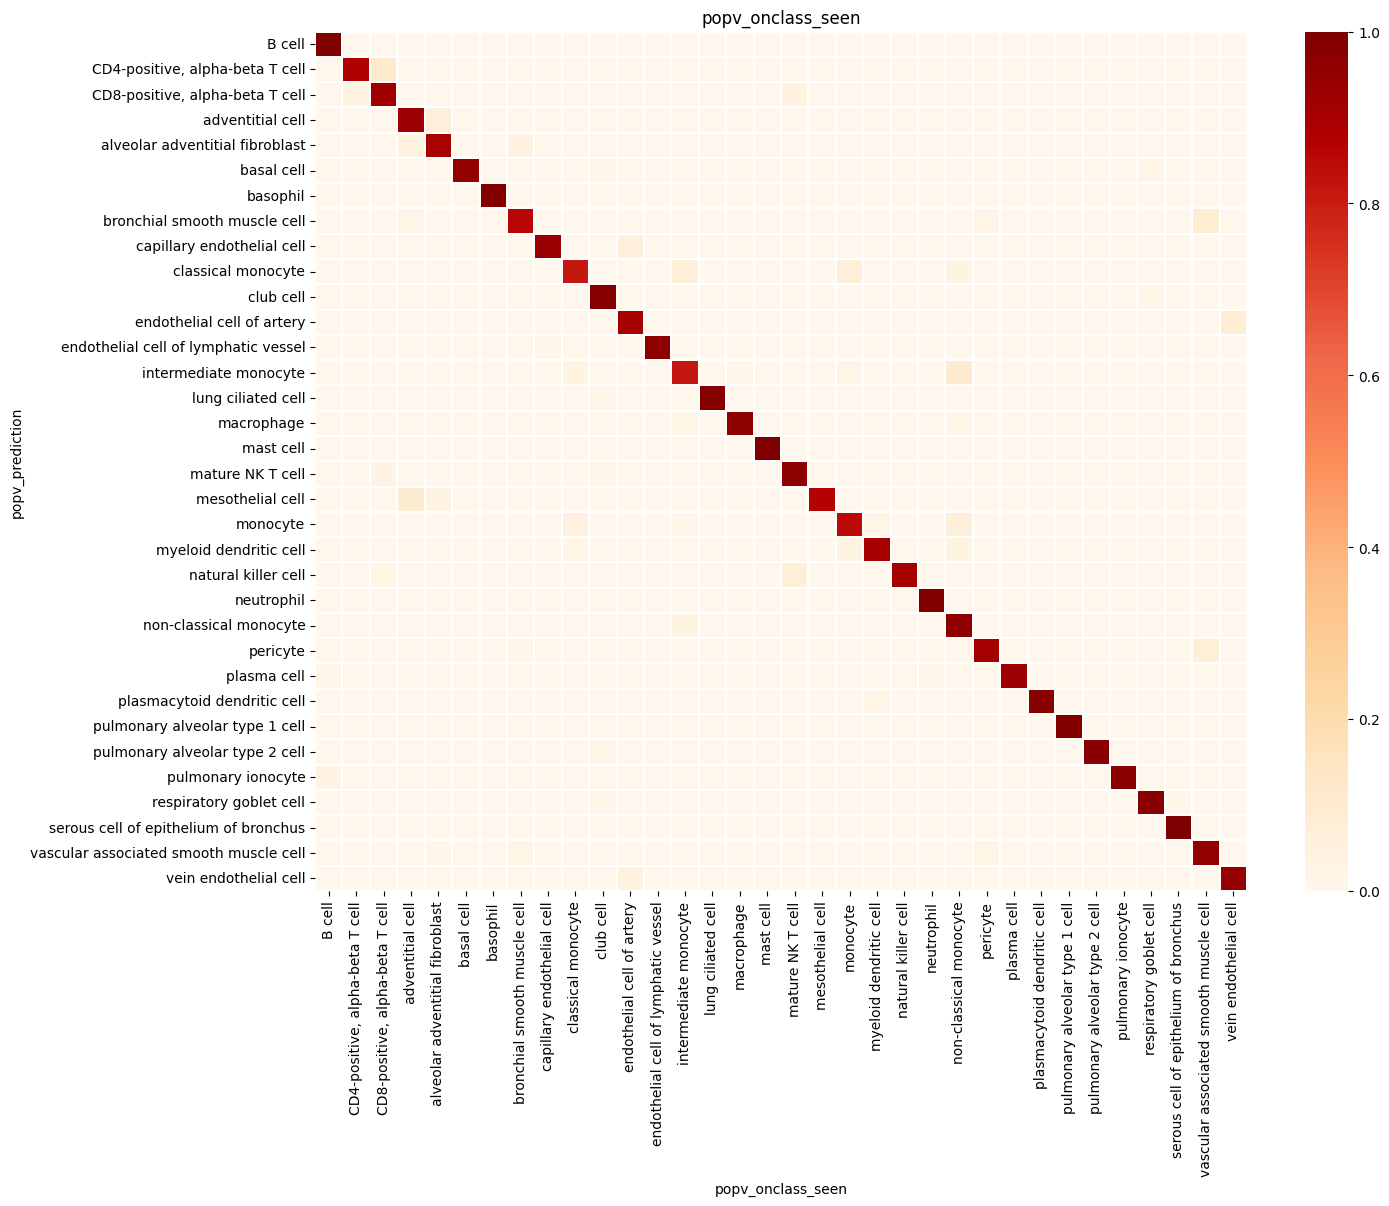

In [16]:
popv.visualization.make_agreement_plots(
    adata,
    prediction_keys=adata.uns["prediction_keys"] + ["popv_onclass_seen"],
)

<Axes: title={'center': 'PopV Prediction Score'}, xlabel='Score', ylabel='Frequency'>

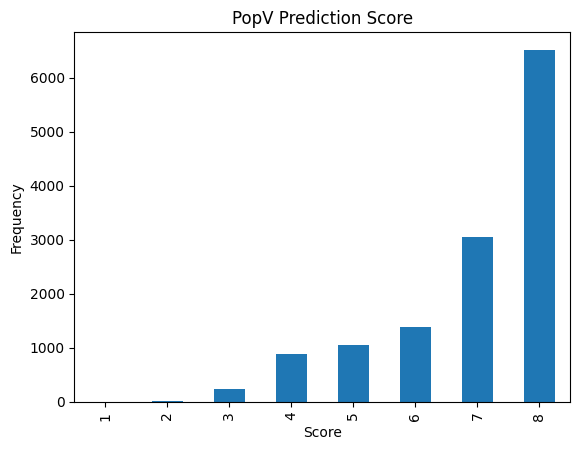

In [17]:
popv.visualization.prediction_score_bar_plot(adata, popv_prediction_score="popv_prediction_score")

<Axes: ylabel='Mean Agreement'>

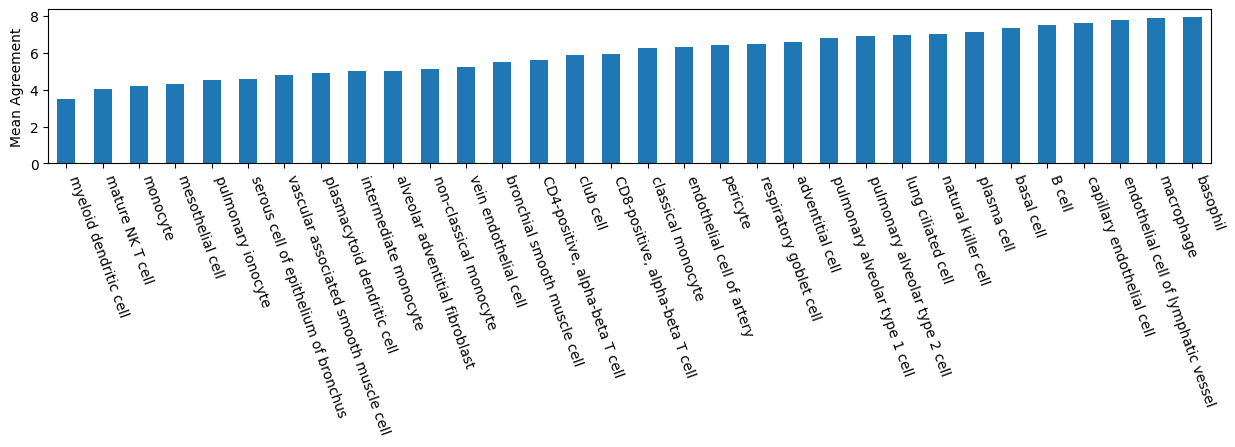

In [18]:
popv.visualization.agreement_score_bar_plot(adata)

### Cell type proportion plot

<Axes: ylabel='Celltype Abundance'>

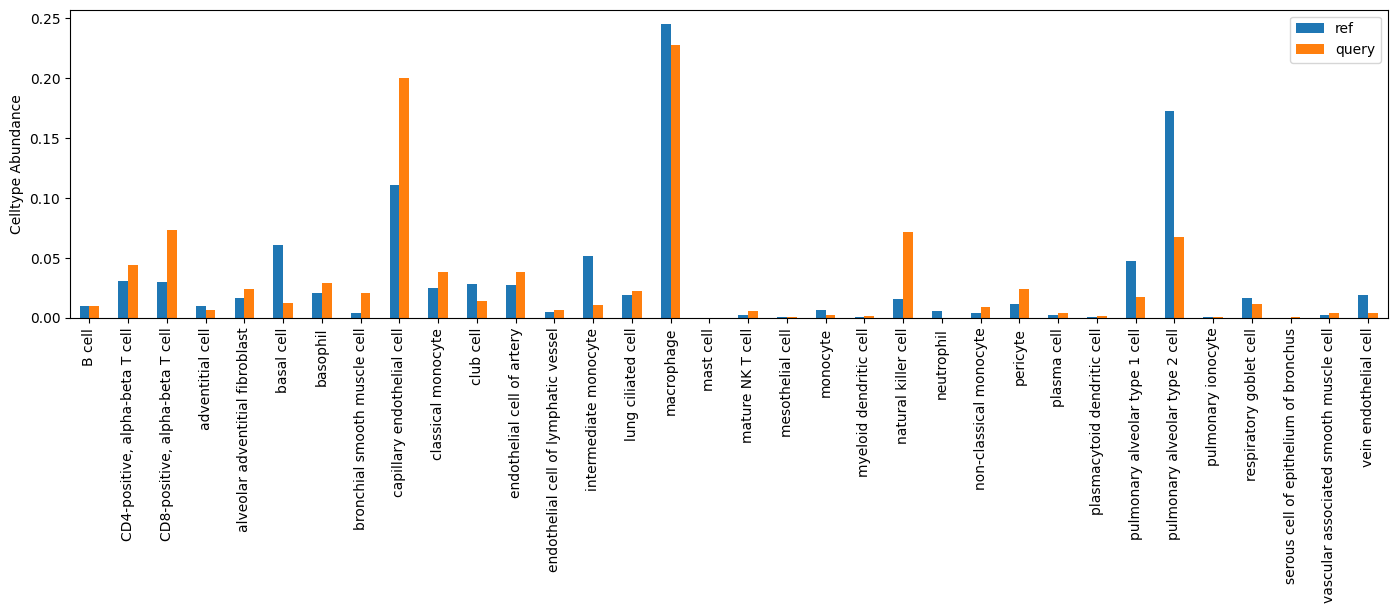

In [19]:
popv.visualization.celltype_ratio_bar_plot(adata)